In [2]:
!pip install -q git+https://github.com/tensorflow/examples.git

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from IPython.display import clear_output
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow_examples'

In [7]:
from tensorflow.python.client import device_lib
%tensorflow_version 2.x
import tensorflow as tf
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12002590796141667372
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2110793684168176722
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1931987135834869840
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7304675328
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8648224002109278391
physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"
]


In [8]:
builder = tfds.builder('oxford_iiit_pet:3.1.0')
info = builder.info
print(info)
# by setting register_checksums as True to pass the check
config = tfds.download.DownloadConfig(register_checksums = True)
builder.download_and_prepare(download_config=config)
dataset = builder.as_dataset()

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.1.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.
',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and J

In [27]:
dataset

{'test': <DatasetV1Adapter shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>,
 'train': <DatasetV1Adapter shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>}

In [0]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [0]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [0]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [0]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [0]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [0]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [0]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

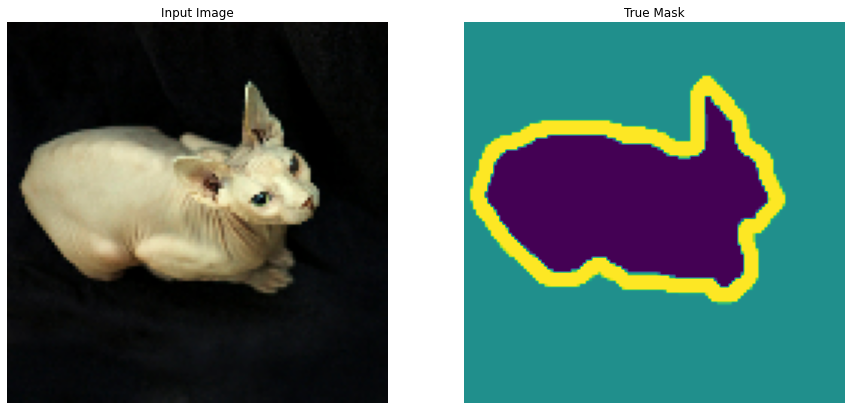

In [17]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [18]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [0]:
# upsample function utilizing tf.keras.layers.Conv2D, size=4, strides=2, default set to be 2x resolution
def upsample(filters, size=4, strides=2, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=strides,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [0]:
def fcn_model(classes=3, drop_out_rate=0.2):
    # use dropout and bacth normalization to prevent overfitting and help to do quick convergence
    # activation layer is added to incorporate non-linearity
    
    # input layer has variable length in width and height, tested on both 512, 1024
    input_imgs = tf.keras.layers.Input(shape=(None, None, 3))
    
    # First conv layer + max pooling
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='same')(input_imgs)
    x = tf.keras.layers.Dropout(drop_out_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)
    
    # Second conv layer + max pooling
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same')(pool1)
    x = tf.keras.layers.Dropout(drop_out_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)
    
    # Third conv layer + max pooling
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(pool2)
    x = tf.keras.layers.Dropout(drop_out_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)
    
    # Forth conv layer + max pooling
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(pool3)
    x = tf.keras.layers.Dropout(drop_out_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)  
    
    # Fifth conv layer + max pooling
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=11, strides=1, padding="same")(pool4)
    x = tf.keras.layers.Dropout(drop_out_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    pool5 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)
    
    # build the fully connected layer using 1*1 convolutional layer
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=1, strides=1, padding="same")(pool5)
    x = tf.keras.layers.Dropout(drop_out_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    conv6 = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filters=classes, kernel_size=1, strides=1, padding="same")(conv6)
    x = tf.keras.layers.Dropout(drop_out_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    conv7 = tf.keras.layers.Activation('sigmoid')(x)

    # upsampling conv7 to 4x times and upsample pool4 to 2x times
    up_conv7 = upsample(filters=classes, size=8, strides=4)(conv7)
    up_pool4 = upsample(filters=64)(pool4)
    
    # Concatenate two resolutions
    fuse_1 = tf.keras.layers.Concatenate()([up_conv7, up_pool4])
    fuse_2 = tf.keras.layers.Concatenate()([fuse_1, pool3])
    
    prob = upsample(filters=classes, size=16, strides=8)(fuse_2)
    model = tf.keras.Model(inputs=input_imgs, outputs=prob)
    
    print(model.summary())
    print("FCN model building completes")
    
    return model

In [74]:
# total number of output being 3 masks (white, grey, background)
# this loss functon is recommended for segmentation masks
model = fcn_model(3)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, None, None, 1 1216        input_14[0][0]                   
__________________________________________________________________________________________________
dropout_91 (Dropout)            (None, None, None, 1 0           conv2d_91[0][0]                  
__________________________________________________________________________________________________
batch_normalization_152 (BatchN (None, None, None, 1 64          dropout_91[0][0]                 
___________________________________________________________________________________________

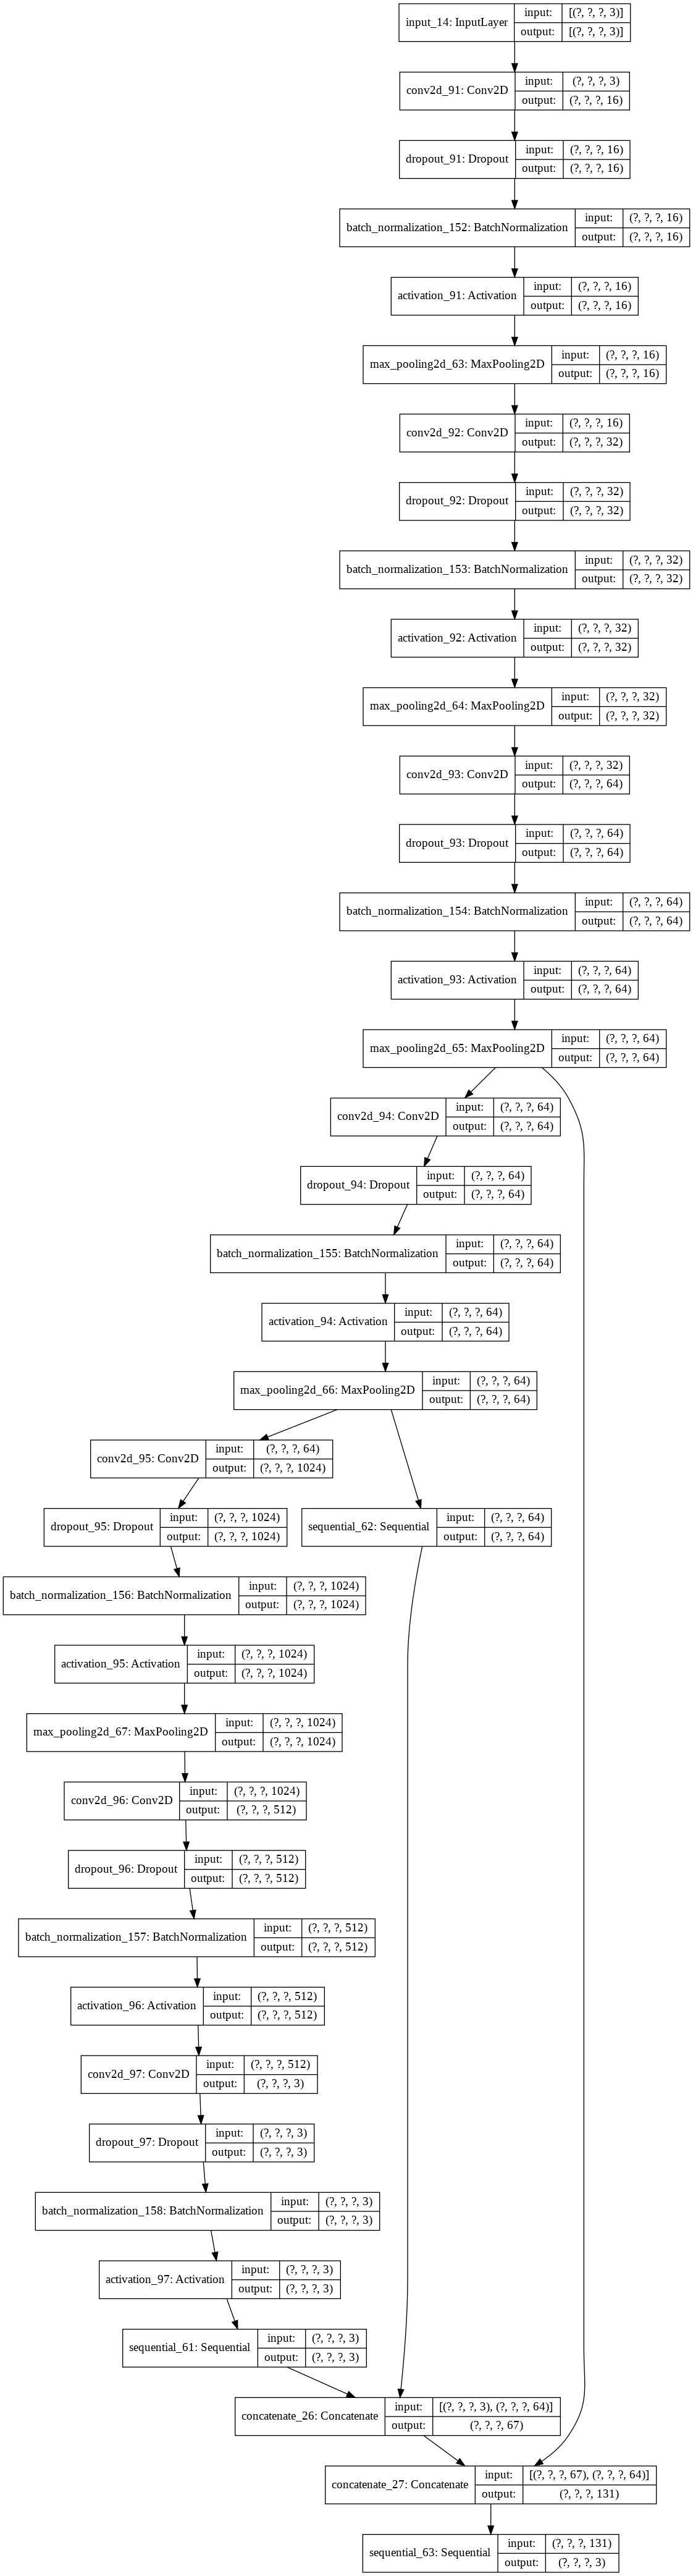

In [75]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [0]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

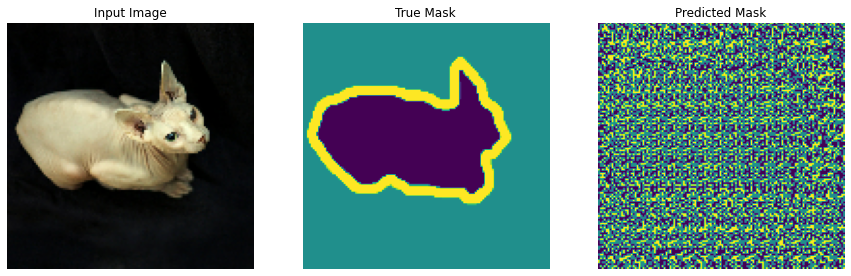

In [78]:
show_predictions()

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

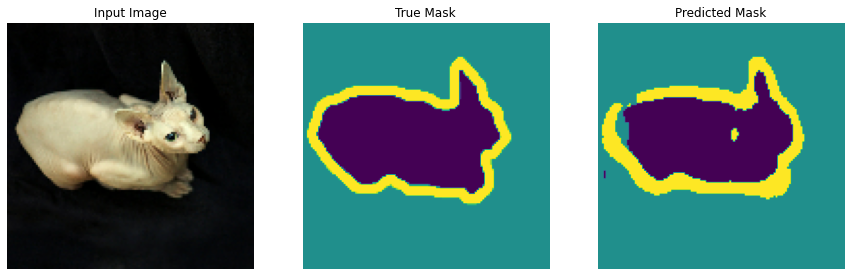


Sample Prediction after epoch 200

57/57 [==============================] - 9s 157ms/step - loss: 0.1357 - accuracy: 0.9374 - val_loss: 0.4067 - val_accuracy: 0.8428


In [83]:
EPOCHS = 200
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])